# Analyse exploratoire

In [53]:
import sys
from pathlib import Path
from typing import Callable

APP_DIR = Path.cwd().parent
sys.path.append(APP_DIR.as_posix())

In [54]:
# Imports EDA
import pandas as pd
import numpy as np
from scipy import stats

In [55]:
# Imports graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Accessibilité : Daltonisme, Dyslexie, Confort Visuel
sns.set_theme(
    style="whitegrid",
    palette="colorblind",
    context="notebook",
)

plt.rcParams.update(
    {
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "font.family": "Arial",
        "font.size": 12,
        "axes.titlesize": 15,
        "axes.titleweight": "bold",
        "axes.labelsize": 13,
        "axes.labelweight": "medium",
        "axes.edgecolor": "black",
        "axes.linewidth": 1.2,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "lines.linewidth": 2.2,
        "lines.markersize": 7,
        "legend.fontsize": 11,
        "legend.frameon": True,
        "legend.framealpha": 0.95,
        "grid.linestyle": ":",
        "grid.linewidth": 0.8,
        "grid.alpha": 0.6,
    }
)

COLORBLIND_PALETTE = sns.color_palette("colorblind")

In [56]:
# Imports storages
from src.storages import PostgresStorage
from src.storages import MongoStorage
from src.storages import MinIOStorage

postgres = PostgresStorage()
mongo = MongoStorage()
minio = MinIOStorage()

# GuitarSet

## Métadata (PostgreSQL)

In [57]:
df_metadata = pd.DataFrame(postgres.select_dataset(dataset_name="GuitarSet"))
df_metadata = df_metadata[
    [
        "guitarist_id",
        "title",
        "style",
        "tempo",
        "scale",
        "mode",
        "playing_version",
        "duration",
    ]
]
df_metadata.head()

,guitarist_id,title,style,tempo,scale,mode,playing_version,duration
0,0,00_BN1-129-Eb_comp,BN1,129,Eb,major,comp,22.3244
1,0,00_BN1-129-Eb_solo,BN1,129,Eb,major,solo,22.3244
2,0,00_BN1-147-Gb_comp,BN1,147,F#,major,comp,19.5856
3,0,00_BN1-147-Gb_solo,BN1,147,F#,major,solo,19.5856
4,0,00_BN2-131-B_comp,BN2,131,B,minor,comp,29.3064


In [58]:
df_metadata.info()

<class 'pandas.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   guitarist_id     360 non-null    int64  
 1   title            360 non-null    str    
 2   style            360 non-null    str    
 3   tempo            360 non-null    int64  
 4   scale            360 non-null    str    
 5   mode             360 non-null    str    
 6   playing_version  360 non-null    str    
 7   duration         360 non-null    float64
dtypes: float64(1), int64(2), str(5)
memory usage: 22.6 KB


Observations :
- Ni valeur nulle, ni valeur manquante.
- Présence de variables numériques et catégorielles.

### Varaibles catégorielles

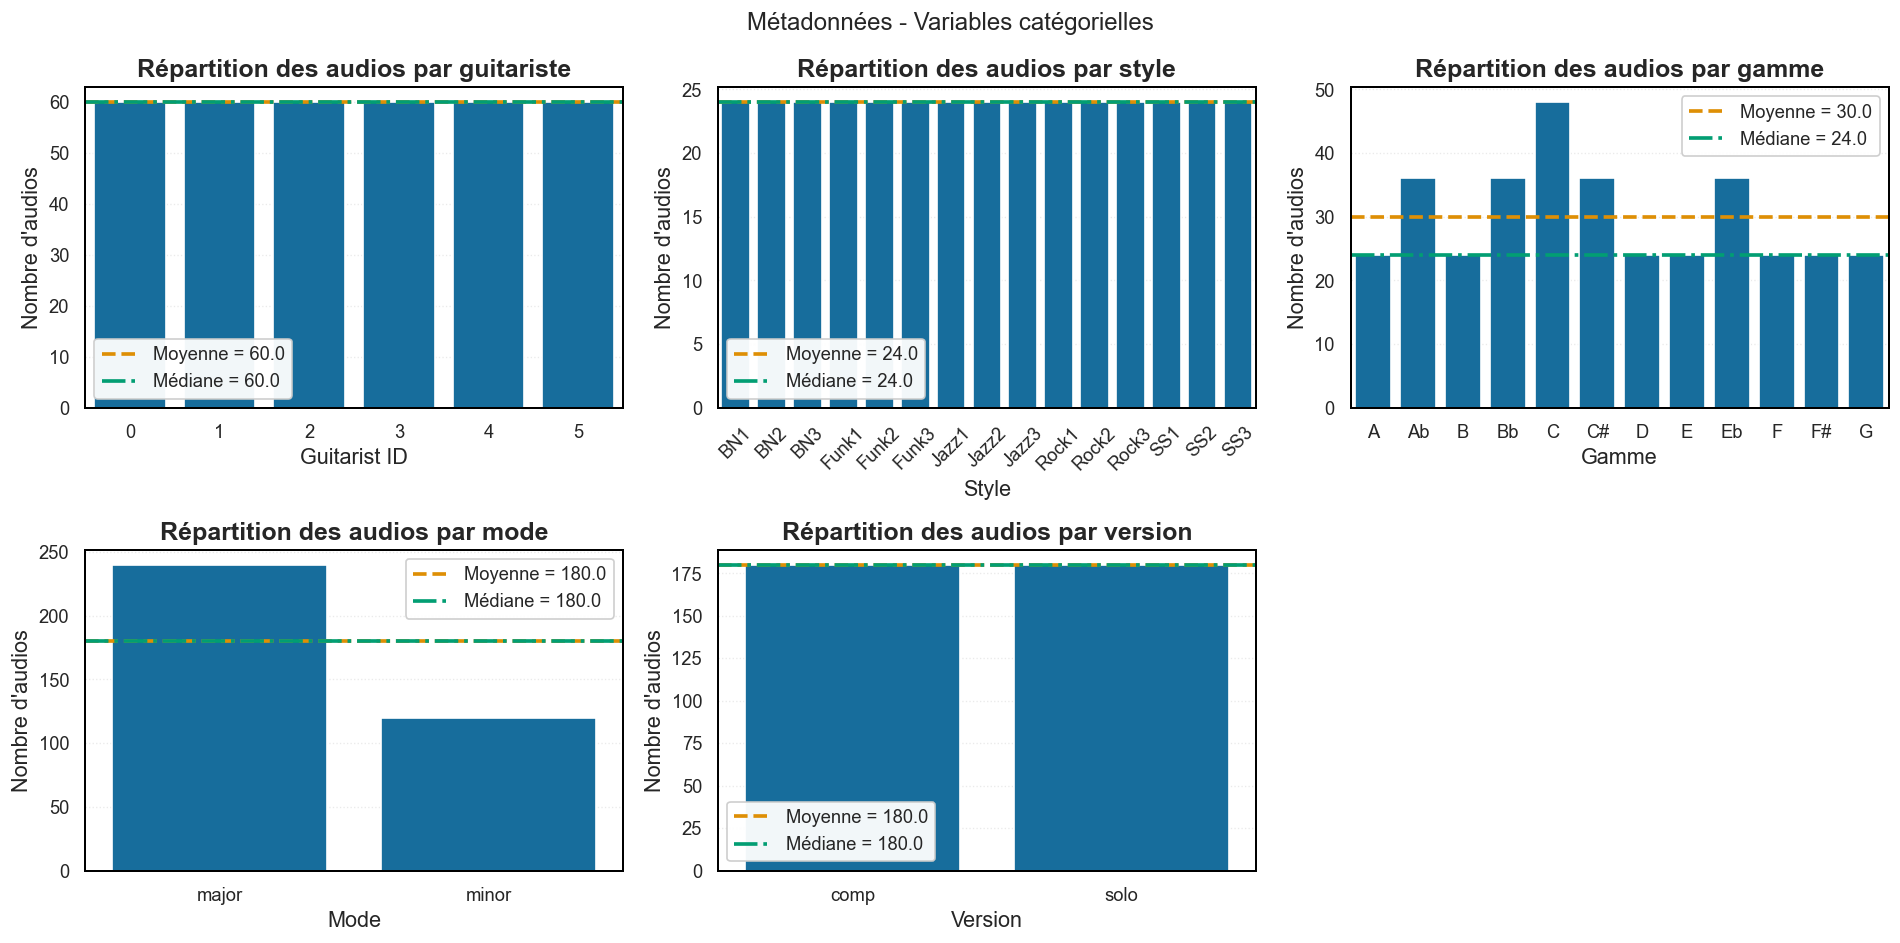

In [59]:
def create_barplot(ax, df, column, rotation=0):
    df_grpby = df.groupby(column).agg(size=(column, "size")).reset_index()

    sns.barplot(
        data=df_grpby,
        x=column,
        y="size",
        ax=ax,
    )

    mean_column = df_grpby["size"].mean()
    median_column = df_grpby["size"].median()

    ax.axhline(
        mean_column,
        color=COLORBLIND_PALETTE[1],
        linestyle="--",
        label=f"Moyenne = {mean_column:.1f}",
    )

    ax.axhline(
        median_column,
        color=COLORBLIND_PALETTE[2],
        linestyle="-.",
        label=f"Médiane = {median_column:.1f}",
    )

    ax.grid(axis="y", linestyle=":", alpha=0.4)
    ax.legend(frameon=True)

    if rotation:
        ax.tick_params(axis="x", rotation=rotation)


fig, axes = plt.subplots(2, 3, figsize=(16, 8))

fig.suptitle("Métadonnées - Variables catégorielles")

# ===
# Répartition des audios par guitarist_id
# ===
ax1 = axes[0, 0]
create_barplot(ax=ax1, df=df_metadata, column="guitarist_id")
ax1.set_title("Répartition des audios par guitariste")
ax1.set_xlabel("Guitarist ID")
ax1.set_ylabel("Nombre d'audios")

# ===
# Répartition des audios par style
# ===
ax2 = axes[0, 1]
create_barplot(ax=ax2, df=df_metadata, column="style", rotation=45)
ax2.set_title("Répartition des audios par style")
ax2.set_xlabel("Style")
ax2.set_ylabel("Nombre d'audios")

# ===
# Répartition des audios par scale
# ===
ax3 = axes[0, 2]
create_barplot(ax=ax3, df=df_metadata, column="scale")
ax3.set_title("Répartition des audios par gamme")
ax3.set_xlabel("Gamme")
ax3.set_ylabel("Nombre d'audios")

# ===
# Répartition des audios par mode
# ===
ax4 = axes[1, 0]
create_barplot(ax=ax4, df=df_metadata, column="mode")
ax4.set_title("Répartition des audios par mode")
ax4.set_xlabel("Mode")
ax4.set_ylabel("Nombre d'audios")

# ===
# Répartition des audios par playing_version
# ===
ax5 = axes[1, 1]
create_barplot(ax=ax5, df=df_metadata, column="playing_version")
ax5.set_title("Répartition des audios par version")
ax5.set_xlabel("Version")
ax5.set_ylabel("Nombre d'audios")

axes[1, 2].set_axis_off()

fig.tight_layout()
plt.show()

In [60]:
df_mode = df_metadata["mode"].value_counts()
print("Répartition des audios par mode :")
for mode in df_mode.index:
    print(
        f"  Pourcentage d'audio en mode {mode} : {df_mode.loc[mode] / df_mode.sum() * 100:.2f}%"
    )

df_scale = df_metadata["scale"].value_counts()
print("\nRépartition des audios par scale :")
for scale in df_scale.index:
    print(
        f"  Pourcentage d'audio en gamme {scale} : {df_scale.loc[scale] / df_scale.sum() * 100:.2f}%"
    )

Répartition des audios par mode :
  Pourcentage d'audio en mode major : 66.67%
  Pourcentage d'audio en mode minor : 33.33%

Répartition des audios par scale :
  Pourcentage d'audio en gamme C : 13.33%
  Pourcentage d'audio en gamme Eb : 10.00%
  Pourcentage d'audio en gamme Ab : 10.00%
  Pourcentage d'audio en gamme C# : 10.00%
  Pourcentage d'audio en gamme Bb : 10.00%
  Pourcentage d'audio en gamme F# : 6.67%
  Pourcentage d'audio en gamme B : 6.67%
  Pourcentage d'audio en gamme G : 6.67%
  Pourcentage d'audio en gamme E : 6.67%
  Pourcentage d'audio en gamme A : 6.67%
  Pourcentage d'audio en gamme D : 6.67%
  Pourcentage d'audio en gamme F : 6.67%


Observations :
- Les varaibles `guitarist_id`, `style` et `playing_version` sont équiréparties.
- La répartition de la varaible `scale` est n'est pas uniforme et a pour mode `C` (Gamme de Do) regroupant environ 13% des audios.
- La répartition de la variable `mode` est déséquilibrée et a pour mode la `major` (gamme majeure) regroupant envirion 67% des audios.

Hypothèse :
- Le déséquilibre de la classe `mode` peut avoir un impact sur l'apprentissage et devrait être considéré lors de la division du dataset en jeu d'entraînement et jeu de test.

In [61]:
def compute_cramers_v(x: pd.Series, y: pd.Series) -> float:
    contingency_table = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))


def compute_contingency_pearson(x: pd.Series, y: pd.Series) -> float:
    contingency_table = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n + chi2))


def compute_tschuprow(x: pd.Series, y: pd.Series) -> float:
    contingency_table = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * np.sqrt((k - 1) * (r - 1))))


METHODS: dict[str, Callable] = {
    "cramers_v": compute_cramers_v,
    "contingency_pearson": compute_contingency_pearson,
    "tschuprow": compute_tschuprow,
}


def compute_cat_corr_df(
    df: pd.DataFrame, cat_vars: list, method: str = "cramers_v"
) -> pd.DataFrame:
    method = METHODS.get(method, None)
    if method is None:
        raise ValueError(f"method accepted: {list(METHODS.keys())}")
    cat_corr_mat = np.zeros((len(cat_vars), len(cat_vars)))
    for i in range(len(cat_vars)):
        for j in range(len(cat_vars)):
            cat_corr_mat[i, j] = method(
                df_metadata[cat_vars[i]], df_metadata[cat_vars[j]]
            )
    return pd.DataFrame(cat_corr_mat)


cat_vars = ["guitarist_id", "style", "scale", "mode", "playing_version"]
cat_corr_df = compute_cat_corr_df(df=df_metadata, cat_vars=cat_vars, method="cramers_v")

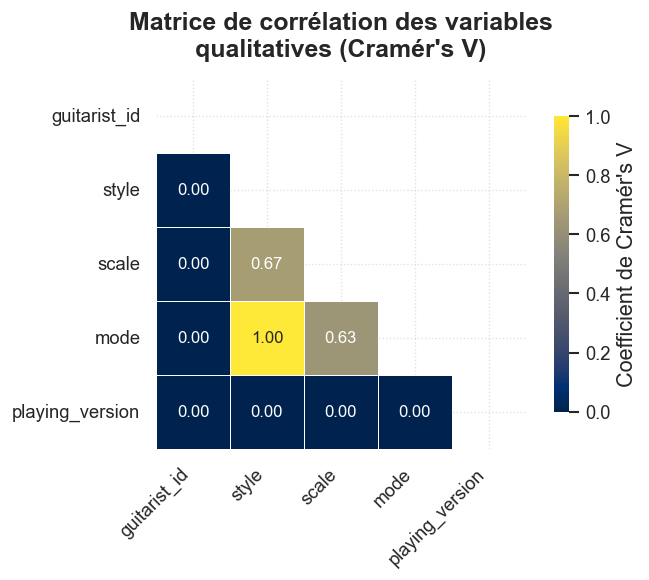

In [80]:
fig, ax = plt.subplots(figsize=(7, 5))

heatmap = sns.heatmap(
    cat_corr_df,
    mask=np.triu(np.ones_like(cat_corr_df, dtype=bool)),
    annot=True,
    fmt=".2f",
    cmap="cividis",
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.6,
    linecolor="white",
    cbar_kws={"shrink": 0.8, "pad": 0.04, "label": "Coefficient de Cramér's V"},
    annot_kws={"size": 10},
    ax=ax,
)
ax.set_title("Matrice de corrélation des variables\nqualitatives (Cramér's V)", pad=14)
ax.set_xticklabels(cat_vars, rotation=45, ha="right")
ax.set_yticklabels(cat_vars, rotation=0)

plt.tight_layout()
plt.show()

Observations :
- Corrélation forte entre `mode` et `style`.
- Corrélation modérée entre `scale` et `style` et entre `mode` et `scale`.
- `playing_version` et `guitarist_id` ne présente aucune corrélation avec les autres variables qualitatives.

### Variables numériques

[['N', '360'], ['Moyenne', '122.17'], ['Médiane', '118.00'], ['Écart-type', '30.14'], ['Coefficient de variation', '0.247'], ['Skewness', '0.643'], ['Kurtosis', '0.157'], ['Min', '68.00'], ['Q1 (25%)', '98.00'], ['Q3 (75%)', '142.00'], ['Max', '200.00'], ['Écart inter-quatile', '44.00']]
[['N', '360'], ['Moyenne', '30.47'], ['Médiane', '29.50'], ['Écart-type', '7.92'], ['Coefficient de variation', '0.260'], ['Skewness', '0.228'], ['Kurtosis', '-0.655'], ['Min', '14.40'], ['Q1 (25%)', '24.93'], ['Q3 (75%)', '35.55'], ['Max', '45.71'], ['Écart inter-quatile', '10.62']]


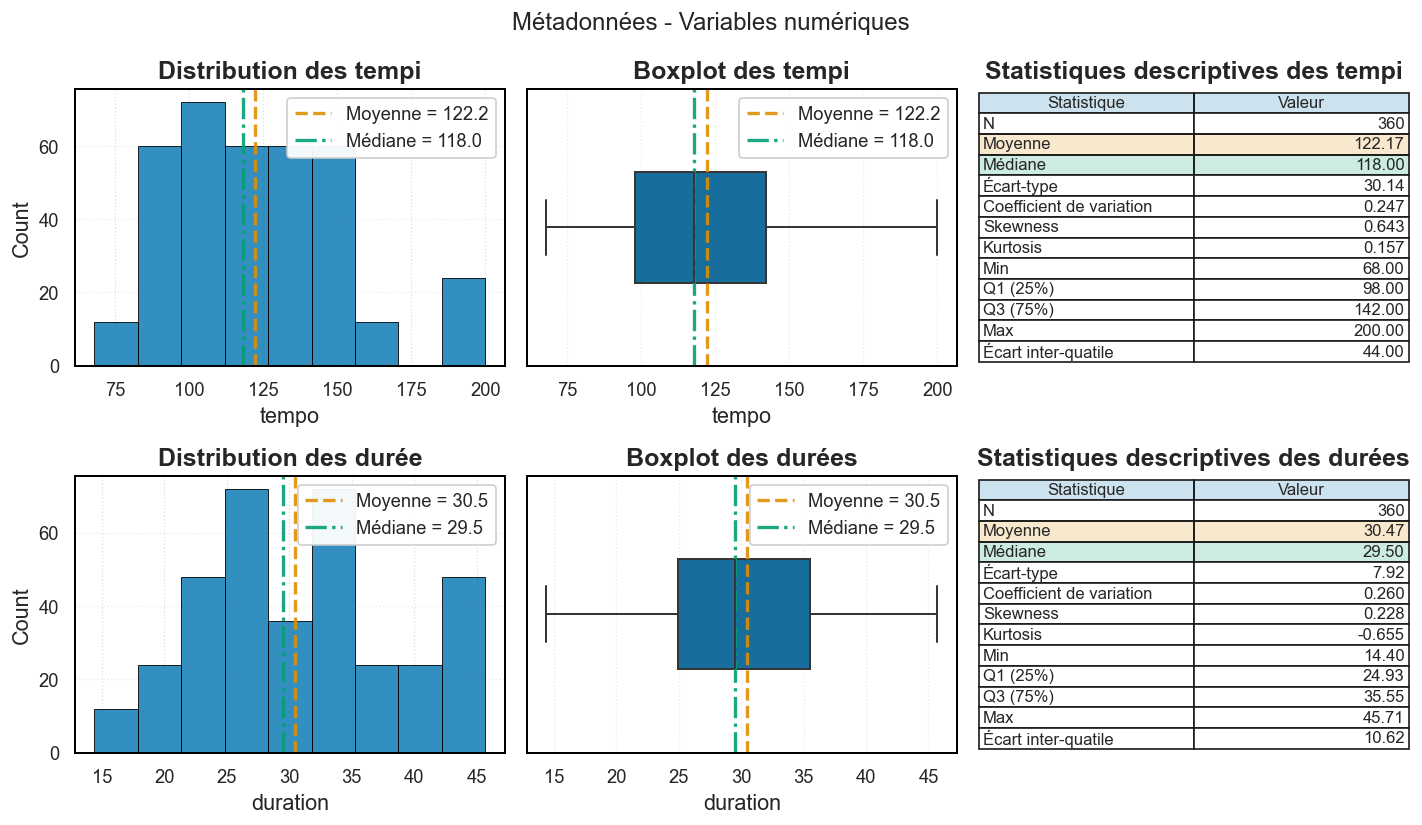

In [63]:
def create_histplot(ax, df, column):
    values = df[column].dropna()

    sns.histplot(
        x=values,
        # bins=int(np.sqrt(len(values))),
        bins=int(1 + np.log2(len(values))),
        color=COLORBLIND_PALETTE[0],
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8,
        ax=ax,
    )

    mean_column = values.mean()
    median_column = values.median()

    ax.axvline(
        mean_column,
        color=COLORBLIND_PALETTE[1],
        linestyle="--",
        linewidth=2,
        alpha=0.9,
        label=f"Moyenne = {mean_column:.1f}",
    )

    ax.axvline(
        median_column,
        color=COLORBLIND_PALETTE[2],
        linestyle="-.",
        linewidth=2,
        alpha=0.9,
        label=f"Médiane = {median_column:.1f}",
    )

    ax.grid(axis="y", linestyle=":", alpha=0.4)
    ax.legend(frameon=True)


def create_boxplot(ax, df, column):
    values = df[column].dropna()

    sns.boxplot(
        x=values,
        ax=ax,
        color=COLORBLIND_PALETTE[0],
        width=0.4,
        fliersize=4,
        linewidth=1.2,
    )

    mean_val = values.mean()
    median_val = values.median()

    ax.axvline(
        mean_val,
        color=COLORBLIND_PALETTE[1],
        linestyle="--",
        linewidth=2,
        alpha=0.9,
        label=f"Moyenne = {mean_val:.1f}",
    )

    ax.axvline(
        median_val,
        color=COLORBLIND_PALETTE[2],
        linestyle="-.",
        linewidth=2,
        alpha=0.9,
        label=f"Médiane = {median_val:.1f}",
    )

    ax.grid(axis="x", linestyle=":", alpha=0.4)
    ax.legend(frameon=True)


def create_stats_panel(ax, df, column):
    values = df[column].dropna()

    mean_val = values.mean()
    std_val = values.std()
    cv = std_val / mean_val if mean_val != 0 else np.nan
    skew = values.skew()
    kurt = values.kurtosis()
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)

    stats_data = [
        ["N", f"{len(values)}"],
        ["Moyenne", f"{mean_val:.2f}"],
        ["Médiane", f"{values.median():.2f}"],
        ["Écart-type", f"{std_val:.2f}"],
        ["Coefficient de variation", f"{cv:.3f}"],
        ["Skewness", f"{skew:.3f}"],
        ["Kurtosis", f"{kurt:.3f}"],
        ["Min", f"{values.min():.2f}"],
        ["Q1 (25%)", f"{q1:.2f}"],
        ["Q3 (75%)", f"{q3:.2f}"],
        ["Max", f"{values.max():.2f}"],
        ["Écart inter-quatile", f"{q3 - q1:.2f}"],
    ]
    print(stats_data)
    table = ax.table(
        cellText=stats_data,
        colLabels=["Statistique", "Valeur"],
        cellLoc="right",
        colLoc="center",
        loc="center",
    )

    # Style
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.1)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_facecolor(COLORBLIND_PALETTE[0] + (0.2,))
        else:
            cell.PAD = 0.02
            if col == 0:
                cell.get_text().set_ha("left")
        if row == 2:
            cell.set_facecolor(COLORBLIND_PALETTE[1] + (0.2,))
        if row == 3:
            cell.set_facecolor(COLORBLIND_PALETTE[2] + (0.2,))

    ax.set_axis_off()


fig, axes = plt.subplots(2, 3, figsize=(12, 7))

fig.suptitle("Métadonnées - Variables numériques")

# ===
# Distribution des tempi
# ===
ax1 = axes[0, 0]
create_histplot(ax=ax1, df=df_metadata, column="tempo")
ax1.set_title("Distribution des tempi")

ax2 = axes[0, 1]
create_boxplot(ax2, df_metadata, "tempo")
ax2.set_title("Boxplot des tempi")

ax3 = axes[0, 2]
create_stats_panel(ax3, df_metadata, "tempo")
ax3.set_title("Statistiques descriptives des tempi")

# ===
# Distribution des durée
# ===
ax4 = axes[1, 0]
create_histplot(ax=ax4, df=df_metadata, column="duration")
ax4.set_title("Distribution des durée")

ax5 = axes[1, 1]
create_boxplot(ax5, df_metadata, "duration")
ax5.set_title("Boxplot des durées")

ax6 = axes[1, 2]
create_stats_panel(ax6, df_metadata, "duration")
ax6.set_title("Statistiques descriptives des durées")

fig.tight_layout()
plt.show()

Observations :
- **tempo**
  - Les tempi varient de 68bpm à 200bpm, présentant une étendue de 132bpm.
  - La moyenne est légérement supérieure à la médiane, ce qui indique une légère asymétrie positive (à droite).
  - Au moins la moitié des tempi sont inférieurs ou égaux à 118bpm. Quelques valeurs élevées influencent légèrement la moyenne.
  - Le coefficient de variation de $\dfrac{\bar{s}}{\bar{x}}\times 100 \simeq 24.7$% indique une dispersion modérée.
  - Au moins la moitié des tempi sont compris entre Q1=98bpm et Q3=142bpm présentant un intervalle inter-quartile de 44bpm.
  - L’intervalle inter-quartile est raisonnable par rapport à la moyenne $\dfrac{IQR}{\bar{s}} \simeq 36$%.
  - Le rapport IQR sur écart-type de $\dfrac{IQR}{\bar{s}} \simeq 1.46$% est légérement supérieur à 1.35, indiquant une légère concentration centrale, une distribution légérement pointue, la possibilité d’une distribution leptokurtique.
  - Le skewness de 0.643 confirme une asymétrique positive modérée.
  - Le kurtosis de 0.157 confirme une distribution légérement leptokurtique.
  - Pas de outlier apparant par la méthode de Turkey, $Q1 - 1.5\times IQR = 32$ et $Q3 + 1.5\times IQR = 208$.
  - La variabilité provient surtout de la dispersion générale plutôt que d’extrêmes très isolés.

- **duration**
  - Les durées varient de 14.4s à 45.71s, présentant une étendue de 31,31s.
  - La moyenne est légérement supérieure à la médiane, ce qui indique une légère asymétrie positive (à droite).
  - Au moins la moitié des durée sont inférieures ou égales à 29.5s. Quelques valeurs élevées influencent légèrement la moyenne.
  - Le coefficient de variation de $\dfrac{\bar{s}}{\bar{x}}\times 100 \simeq 26$% indique une dispersion modérée.
  - Au moins la moitié des durées sont comprises entre Q1=24.93s et Q3=35.55s présentant un intervalle inter-quartile de 10.62s.
  - L’intervalle inter-quartile est raisonnable par rapport à la moyenne $\dfrac{IQR}{\bar{s}} \simeq 34,85$%.
  - Le rapport IQR sur écart-type de $\dfrac{IQR}{\bar{s}} \simeq 1.34$% est très proche de 1.35, indiquant une distribution compatible avec une normale, l'absence d'effet extrême majeur, une dispersion homogène.
  - Le skewness de 0.228 confirme une faible asymétrie positive, proche de la symétrie.
  - Le kurtosis de -0.655 indique une distribution platykurtique.
  - Pas de outlier apparant par la méthode de Turkey, $Q1 - 1.5\times IQR = 9$ et $Q3 + 1.5\times IQR = 51.48$.
  - La variabilité provient surtout de la dispersion générale plutôt que d’extrêmes très isolés.

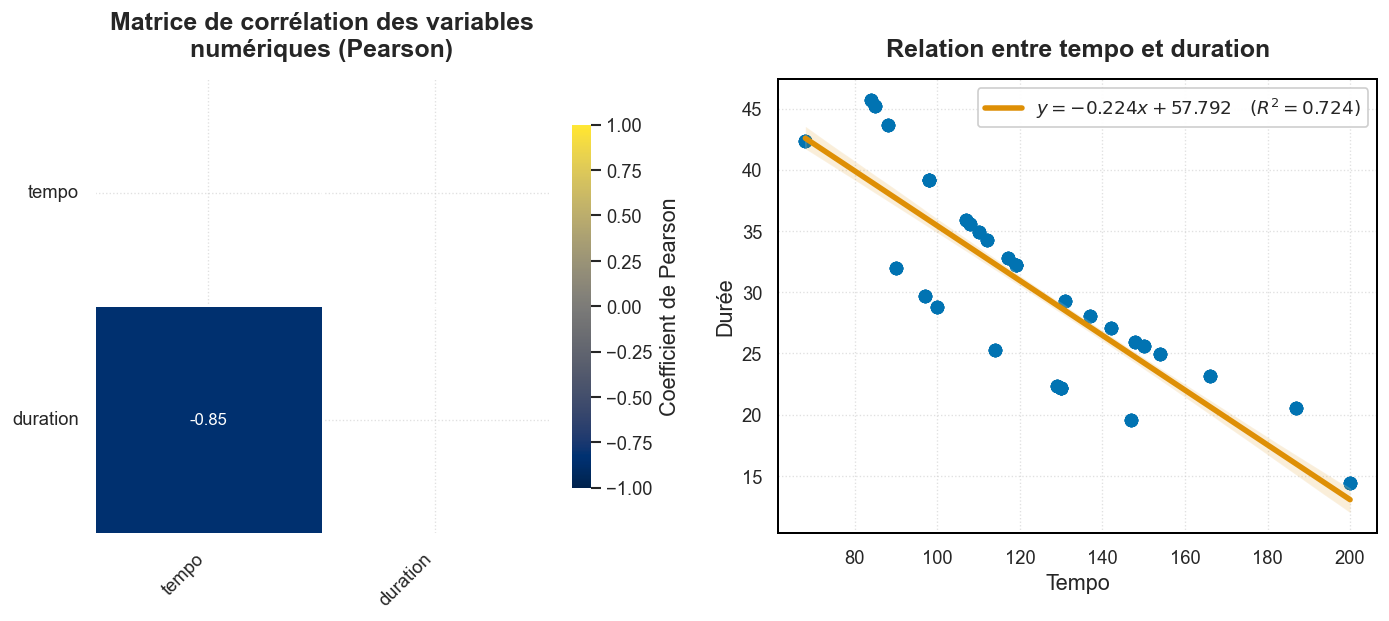

In [ ]:
num_vars = ["tempo", "duration"]
num_corr_df = df_metadata[num_vars].corr(method="pearson")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ===
# Heatmap matrice de corrélation
# ===
ax1 = axes[0]
heatmap = sns.heatmap(
    num_corr_df,
    mask=np.triu(np.ones_like(num_corr_df, dtype=bool)),
    annot=True,
    fmt=".2f",
    cmap="cividis",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.6,
    linecolor="white",
    cbar_kws={"shrink": 0.8, "pad": 0.04, "label": "Coefficient de Pearson"},
    annot_kws={"size": 10},
    ax=ax1,
)
ax1.set_title("Matrice de corrélation des variables\nnumériques (Pearson)", pad=14)
ax1.set_xticklabels(num_vars, rotation=45, ha="right")
ax1.set_yticklabels(num_vars, rotation=0)

# ===
# Scatterplot tempo vs duration
# ===
ax2 = axes[1]

x = df_metadata["tempo"].values
y = df_metadata["duration"].values
a, b = np.polyfit(x, y, 1)
r2 = np.corrcoef(x, y)[0, 1] ** 2
equation = (
    rf"$y = {a:.3f}x {'+' if b >= 0 else '-'} {abs(b):.3f}\quad (R^2 = {r2:.3f})$"
)

sns.regplot(
    data=df_metadata,
    x="tempo",
    y="duration",
    order=1,
    scatter_kws={"color": COLORBLIND_PALETTE[0]},
    line_kws={"color": COLORBLIND_PALETTE[1], "label": equation},
    ax=ax2,
)
ax2.set_title("Relation entre tempo et duration", pad=14)
ax2.set_xlabel("Tempo")
ax2.set_ylabel("Durée")
ax2.legend()

plt.tight_layout()
plt.show()

Observation :
- Forte corrélation négative entre `tempo` et `duration`.
- Suspicion d'une relation quadratique.

### Corrélations entre variables catégorielles et numériques

In [65]:
def calculate_eta2(categories: pd.Series, values: pd.Series) -> float:
    mask = ~pd.isna(categories) & ~pd.isna(values)
    categories = pd.Categorical(categories[mask])
    values = values[mask]

    means = values.groupby(categories).mean()
    n = values.groupby(categories).count()
    total_mean = values.mean()

    inter_categorical_variance = 1 / n.sum() * (n * (means - total_mean) ** 2).sum()
    total_variance = 1 / n.sum() * ((values - total_mean) ** 2).sum()
    return inter_categorical_variance / total_variance


def compute_cat_num_corr_df(
    df: pd.DataFrame, cat_vars: list, num_vars: list
) -> pd.DataFrame:
    eta2_dict = {}
    for cat_var in cat_vars:
        eta2_dict[cat_var] = {}
        for num_var in num_vars:
            eta2_dict[cat_var][num_var] = calculate_eta2(df[cat_var], df[num_var])
    eta2_df = pd.DataFrame(eta2_dict).T[num_vars]
    return eta2_df


cat_num_corr_df = compute_cat_num_corr_df(df_metadata, cat_vars, num_vars)

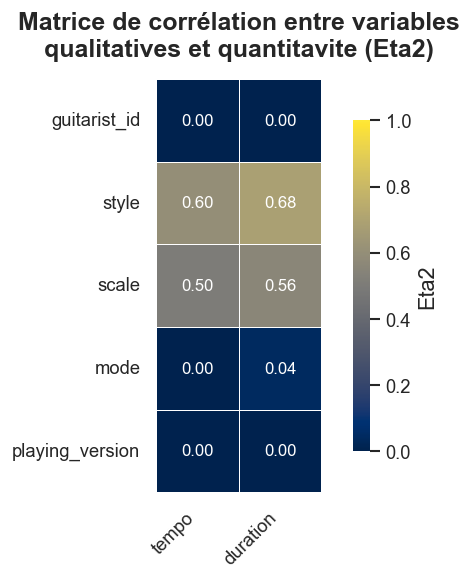

In [66]:
fig, ax = plt.subplots(figsize=(7, 5))

heatmap = sns.heatmap(
    cat_num_corr_df,
    annot=True,
    fmt=".2f",
    cmap="cividis",
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.6,
    linecolor="white",
    cbar_kws={"shrink": 0.8, "pad": 0.04, "label": "Eta2"},
    annot_kws={"size": 10},
    ax=ax,
)
ax.set_title(
    "Matrice de corrélation entre variables\nqualitatives et quantitavite (Eta2)",
    pad=14,
)
ax.set_xticklabels(num_vars, rotation=45, ha="right")
ax.set_yticklabels(cat_vars, rotation=0)

plt.tight_layout()
plt.show()

Observations :
- Corrélation modérée entre `style` et `tempo` et entre `style` et `duration`.
- Corrélation modérée entre `scale` et `tempo` et entre `scale` et `duration`.
- Absence de corrélation entre `guitarist_id`, `mode`, `playing_version` et `tempo` et entre `guitarist_id`, `mode`, `playing_version` et `duration`.

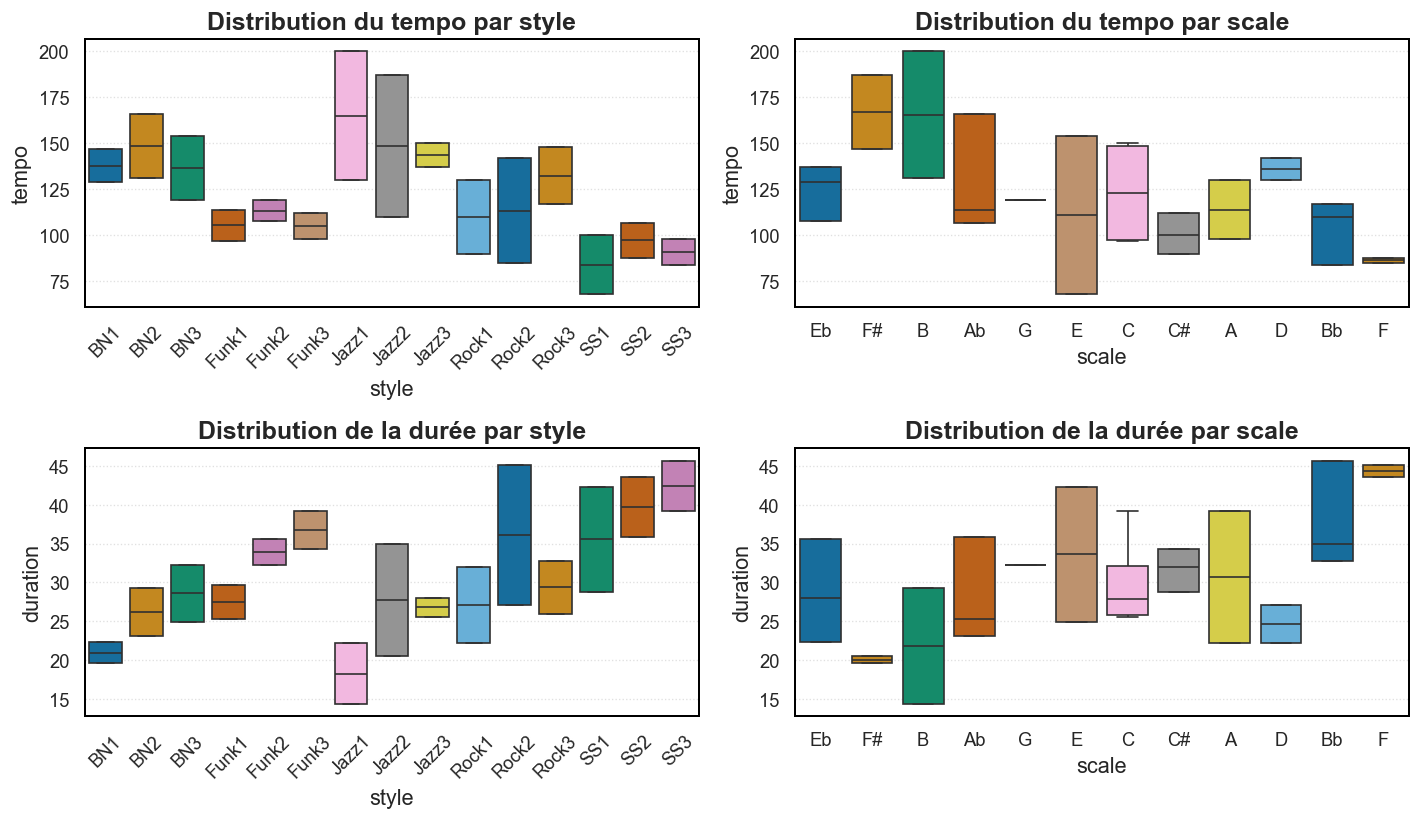

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7))

# ===
# Boxplot Tempo vs Style
# ===
ax1 = axes[0, 0]
sns.boxplot(
    data=df_metadata,
    x="style",
    y="tempo",
    palette="colorblind",
    hue="style",
    legend=False,
    ax=ax1,
)
ax1.set_title("Distribution du tempo par style")
ax1.tick_params(axis="x", rotation=45)

# ===
# Boxplot Tempo vs Scale
# ===
ax2 = axes[0, 1]
sns.boxplot(
    data=df_metadata,
    x="scale",
    y="tempo",
    palette="colorblind",
    hue="scale",
    legend=False,
    ax=ax2,
)
ax2.set_title("Distribution du tempo par scale")

# ===
# Boxplot Duration vs Style
# ===
ax3 = axes[1, 0]
sns.boxplot(
    data=df_metadata,
    x="style",
    y="duration",
    palette="colorblind",
    hue="style",
    legend=False,
    ax=ax3,
)
ax3.set_title("Distribution de la durée par style")
ax3.tick_params(axis="x", rotation=45)

# ===
# Boxplot Duration vs Scale
# ===
ax4 = axes[1, 1]
sns.boxplot(
    data=df_metadata,
    x="scale",
    y="duration",
    palette="colorblind",
    hue="scale",
    legend=False,
    ax=ax4,
)
ax4.set_title("Distribution de la durée par scale")

plt.tight_layout()
plt.show()

Observations :
- 

## Annotations (MongoDB)

In [67]:
pipeline = [
    {"$match": {"dataset_name": "GuitarSet"}},
    {"$count": "*"},
]

print("Nombre de documents par collection :")
for collection in ["note_midi", "beat_position", "chord", "pitch_contour"]:
    print(
        f"  {collection} : ",
        mongo.aggregate_documents(collection_name=collection, pipeline=pipeline)[0].get(
            "*", "ERROR"
        ),
    )

Nombre de documents par collection :
  note_midi :  360
  beat_position :  360
  chord :  360
  pitch_contour :  360


In [68]:
pipeline = [{"$match": {"dataset_name": "GuitarSet"}}]

annotations = mongo.aggregate_documents(collection_name="note_midi", pipeline=pipeline)
df_annotation = pd.DataFrame(annotations)[["title", "note_midi"]]

df_annotation = df_annotation.explode("note_midi")
df_annotation = df_annotation.join(pd.json_normalize(df_annotation["note_midi"]))
df_annotation = df_annotation.drop(columns="note_midi").reset_index(drop=True)

df_annotation["data_source"] = df_annotation["data_source"].astype("int")

df_annotation.head()

,title,data_source,time,duration,value
0,00_BN1-129-Eb_comp,0,7.457274,0.464399,44.018917
1,00_BN1-129-Eb_comp,0,7.923578,0.922993,44.224918
2,00_BN1-129-Eb_comp,0,8.870789,0.191565,44.106065
3,00_BN1-129-Eb_comp,0,14.834689,0.487619,46.053185
4,00_BN1-129-Eb_comp,0,15.333215,1.416417,46.071249


In [69]:
df_annotation.info()

<class 'pandas.DataFrame'>
RangeIndex: 16038538 entries, 0 to 16038537
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   title        str    
 1   data_source  int64  
 2   time         float64
 3   duration     float64
 4   value        float64
dtypes: float64(3), int64(1), str(1)
memory usage: 611.8 MB


[['N', '16038538'], ['Moyenne', '16.84'], ['Médiane', '16.04'], ['Écart-type', '10.45'], ['Coefficient de variation', '0.621'], ['Skewness', '0.381'], ['Kurtosis', '-0.617'], ['Min', '0.00'], ['Q1 (25%)', '8.21'], ['Q3 (75%)', '24.18'], ['Max', '45.50'], ['Écart inter-quatile', '15.96']]


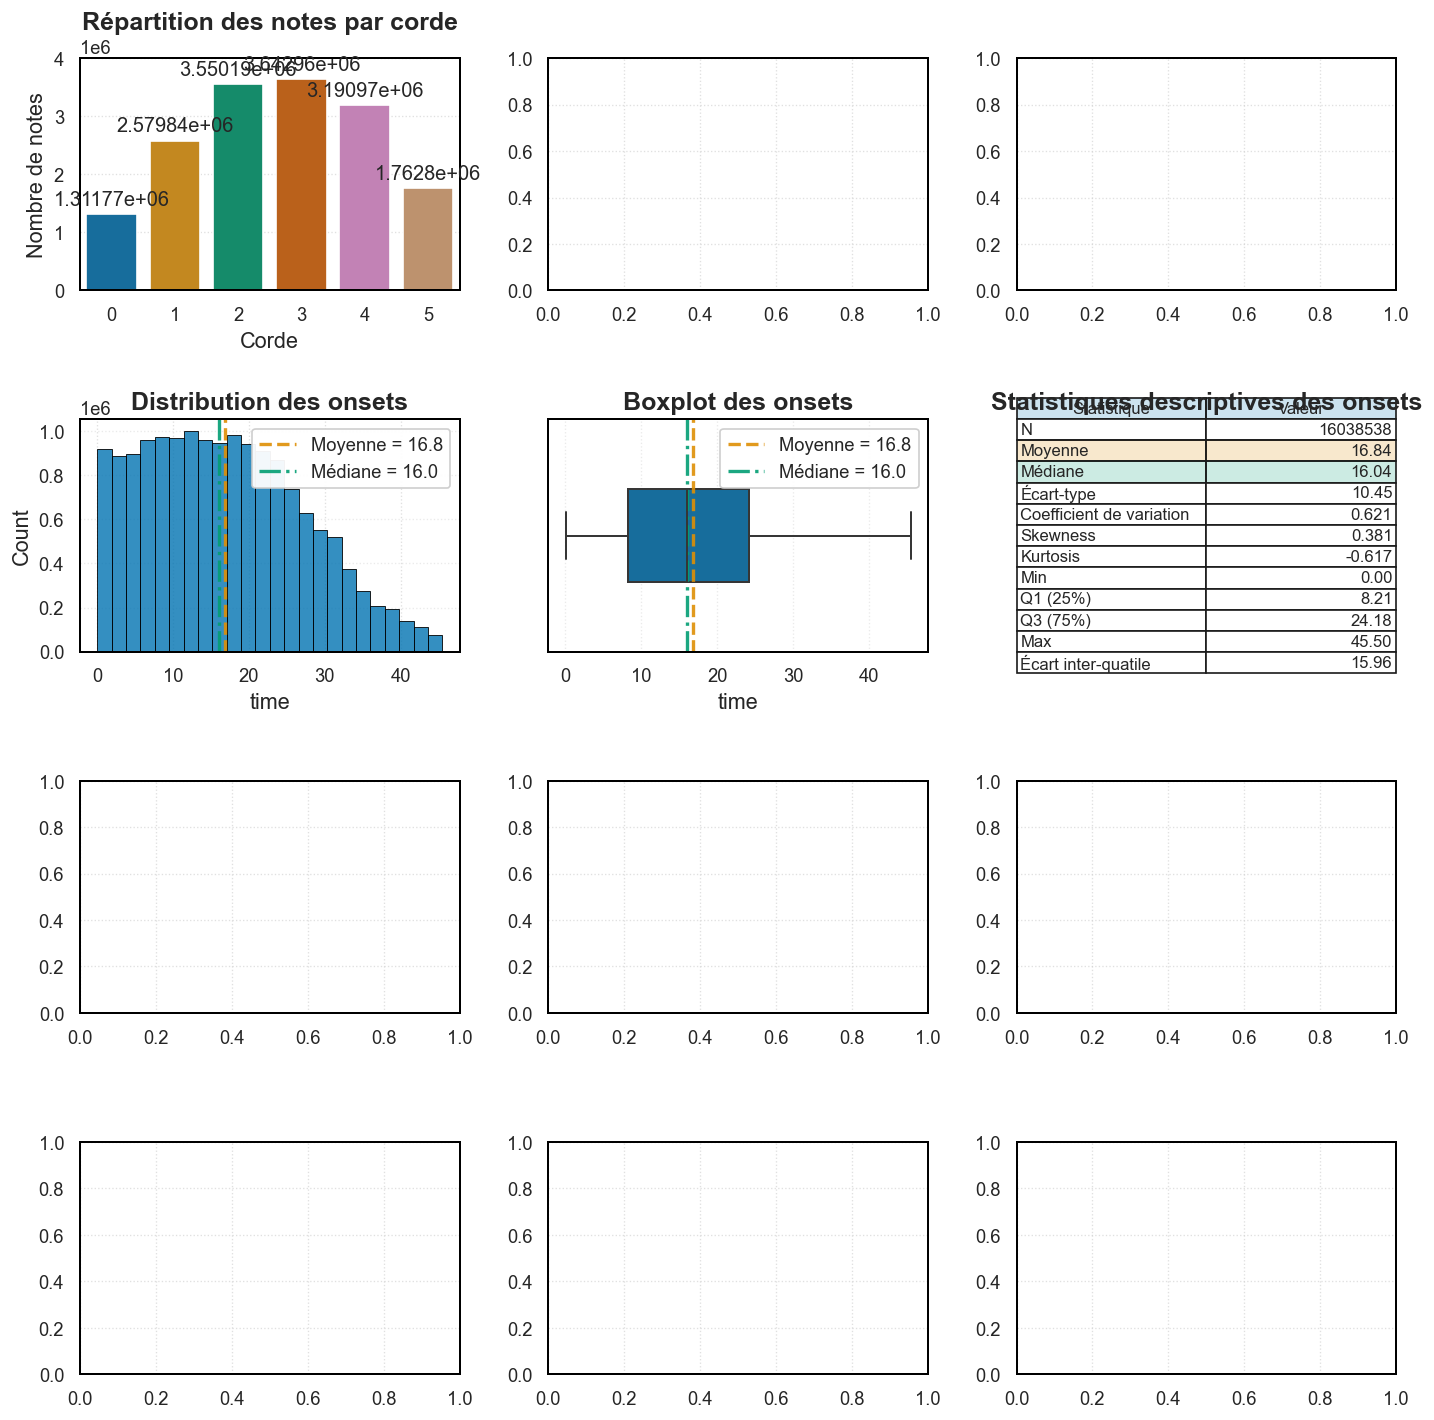

In [ ]:
data_source = df_annotation.groupby("data_source").size()
time = df_annotation.groupby("data_source").size()

fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# ===
# Répartition des notes
# ===
ax1 = axes[0, 0]
barplot = sns.barplot(
    x=data_source.index,
    y=data_source.values,
    palette=COLORBLIND_PALETTE[:6],
    hue=data_source.index,
    legend=False,
    ax=ax1,
)
ax1.set_title("Répartition des notes par corde")
ax1.set_xlabel("Corde")
ax1.set_ylabel("Nombre de notes")
ax1.set_ylim(0, 4 * 10**6)

for container in barplot.containers:
    barplot.bar_label(container, padding=3)

# ===
# Distribution des tempi
# ===
ax4 = axes[1, 0]
create_histplot(ax=ax4, df=df_annotation, column="time")
ax4.set_title("Distribution des onsets")

ax5 = axes[1, 1]
create_boxplot(ax5, df_annotation, "time")
ax5.set_title("Boxplot des onsets")

ax6 = axes[1, 2]
create_stats_panel(ax6, df_annotation, "time")
ax6.set_title("Statistiques descriptives des onsets")

plt.tight_layout()

## Audio (MinIO)

In [71]:
audio_objects = [
    obj for obj in minio.list_raw(prefix="GuitarSet/") if "audio" in obj.object_name
]
print("Nombre d'audio : ", len(audio_objects))
print("Taille total (Go) : ", sum(obj.size for obj in audio_objects) // (1024**3))

Nombre d'audio :  1440
Taille total (Go) :  12
